# Implementing VoxelNet

Implementation details, I referenced the following:

1. https://github.com/baudm/VoxelNet-Keras/blob/master/model.py (MIT license)
2. https://github.com/steph1793/Voxelnet/blob/master/model.py (GPL license)
3. https://github.com/qianguih/voxelnet (No license)

In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

# 0. Functional Keras in action

We'll use Keras extensively, using Tensorflow when needed for special implementation details.

Here we use Keras's 'functional API' to:

1. Easily repeat instantiation of layers, and
2. Create non-sequential compute graphs

Here's an example:

In [19]:
def get_bowtie(input_shape = 128, name="Hello"):
    '''This provides three layers, of 512, 16, and 512 dimensions each.
    
    Think of this like:
    
    --> (Dense 512) --> (Relu) -->  (Dense 16) --> (Relu) -->  (Dense 512) --> (Relu) --> 
    '''
    x1 = keras.layers.Dense(512, activation='relu', name=name+'_1')
    x2 = keras.layers.Dense(16, activation='relu', name=name+'_2')(x1)
    x3 = keras.layers.Dense(512, activation='relu', name=name+'_3')(x2)
    return x3

x1 = keras.Input(shape=(128))
h_1a = get_bowtie(name="h_1a")(x1)
h_1b = get_bowtie(name="h_1b")(x1)
h_2 = keras.layers.concatenate([h_1a, h_1b])
y_out = keras.layers.Dense(2)(h_2)

model = keras.Model(inputs = x1, outputs = y_out)

keras.utils.plot_model(model, show_shapes=True)

AttributeError: 'Dense' object has no attribute 'shape'

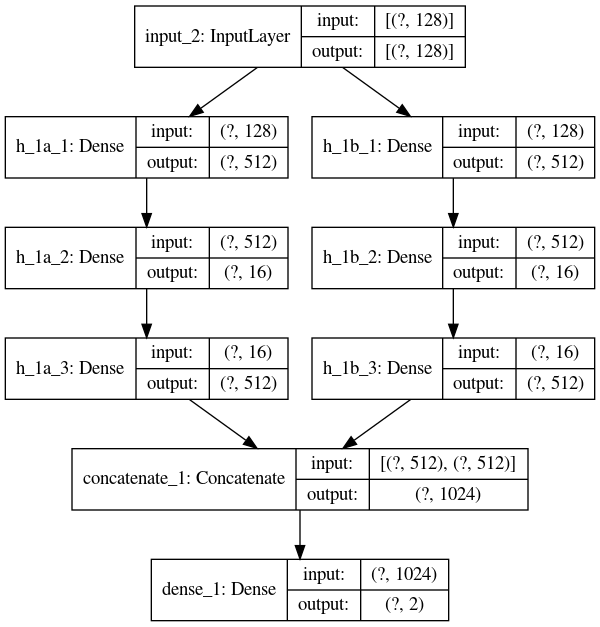

In [9]:
def get_bowtie(input_layer, name="Hello"):
    '''This provides three layers, of 512, 16, and 512 dimensions each.
    
    Think of this like:
    
    --> (Dense 512) --> (Relu) -->  (Dense 16) --> (Relu) -->  (Dense 512) --> (Relu) --> 
    '''
    x1 = keras.layers.Dense(512, activation='relu', name=name+'_1')(input_layer)
    x2 = keras.layers.Dense(16, activation='relu', name=name+'_2')(x1)
    x3 = keras.layers.Dense(512, activation='relu', name=name+'_3')(x2)
    return x3

x1 = keras.Input(shape=(128))
h_1a = get_bowtie(x1, name="h_1a")
h_1b = get_bowtie(x1, name="h_1b")
h_2 = keras.layers.concatenate([h_1a, h_1b])
y_out = keras.layers.Dense(2)(h_2)

model = keras.Model(inputs = x1, outputs = y_out)

keras.utils.plot_model(model, show_shapes=True)

In [10]:
# And just to show it works...
# Let's run a batch of 5 inputs of size 128, getting a batch of 5 inputs of size 2
model(
    tf.convert_to_tensor(
        np.random.rand(5, 128).astype(np.float32)
    )
)

<tf.Tensor: id=582, shape=(5, 2), dtype=float32, numpy=
array([[ 0.03579432,  0.03060058],
       [ 0.02380183,  0.03656149],
       [ 0.057496  , -0.02859712],
       [ 0.01356055,  0.00870097],
       [ 0.09913833,  0.00616339]], dtype=float32)>

We'll use this, because we'll be instantiating a lot of very similar blocks of layers.

---

# 1. Region Proposal Network

Starting with this and working backwards because it is the easiest.

The paper uses this convention for Conv layers:

| `ConvMD(c_in, c_out, k, s, p)` | Meaning |
| - | - |
| `M` | Dimension (i.e. 2, 3) |
| `c_in`   | Input channels 
| `c_out`  | Output channels 
| `k`      | Kernel size, size `M`, where `k = (k, k, k,)` when sizes across dimensions are the same. 
| `s` | Stride
| `p` | Padding

Specifically, for car detection,

- Output from conv layers is `(64, 2, 400, 352)`
- Reshape to `(128, 400, 352)` (channel, height, width)
- Anchors `l^a = 3.9, w^a = 1.6, h^a = 1.56`
- Centered at `z^a_c with rotations 0 and 90 degrees
- Anchor matching criterion:
    - Negative if IoU < 0.45
    - Neutral if 0.45 <= IoU <= 0.6
    - Positive if IoU > 0.6

And for pedestrians,

TODO

---

In [3]:

def get_rpn_conv_block(M, c_in, c_out, kk, ss, pp):
    pass

'''
block_1 = keras.layers.Conv2D(
    filters     = 1,
    kernel_size = 1,
    strides     = (1,1),
    padding     = 'valid',
)
'''

"\nblock_1 = keras.layers.Conv2D(\n    filters     = 1,\n    kernel_size = 1,\n    strides     = (1,1),\n    padding     = 'valid',\n)\n"

# 2. Convolutional Middle Layers

First, let's use the notation as above:

| `ConvMD(c_in, c_out, k, s, p)` | Meaning |
| - | - |
| `M` | Dimension (i.e. 2, 3) |
| `c_in`   | Input channels 
| `c_out`  | Output channels 
| `k`      | Kernel size, size `M`, where `k = (k, k, k,)` when sizes across dimensions are the same. 
| `s` | Stride
| `p` | Padding

Per section 2.1.2, each convolutional middle layer:

1. Applies 3D convolution,
2. Batchnorm,
3. ReLU

This is described better in section 3.

Specifically, for both car and pedestrian detection, the middle layers are sequentially:

1. Conv3D(128, 64, 3, (2,1,1), (1,1,1)),
2. Conv3D(64, 64, 3, (1,1,1), (0,1,1)), 
3. Conv3D(64, 64, 3, (2,1,1), (1,1,1)),
4. yielding a 4D tensor of size 64 × 2 × 400 × 352.

In [11]:
def get_convolutional_middle_layer(
    input_layer
    MM = 3,
    c_in = 64,
    c_out = 64,
    kk =  3,
    ss = (2, 1, 1),
    pp = (1, 1, 1)
):

    '''
    
    See section 2.1.2 "Convolutional Middle Layers" of the VoxelNet paper.
    
    For parameters kk, ss, and pp, these are vectors of size MM,
    but can be instantiated as a scalar.
    
    (E.g. for MM = 3 and kk = 2, this code changes it to kk = (2, 2, 2)
    
    :param input_layer: Keras input layer
    :param MM: Dimension of the convolution, default 3
    :type MM: int
    :param c_in: Number of input channels
    :type c_in: int
    :param c_out: Number of output channels
    :type c_out: int
    :param kk: Kernel size, vector of size MM
    :type kk: tuple or int
    :param ss: Stride size, vector of size MM
    :type ss: tuple or int
    :param pp: Padding size, vector of size MM
    :type pp: tuple or int
    '''
    
    
    # Check all values first
    # (todo: type hint, how to do iterables and union in 3.7?)
    # (todo: consider using pattern matching, if you're willing to break for old python version)
    if not MM == 3:
        raise NotImplementedError("We only support 3D convolutions right now!")
    
    if not isinstance(MM, int):
        raise TypeError("MM must be int")
    if not isinstance(c_in, int):
        raise TypeError("c_in must be int")
    if not isinstance(c_out, int):
        raise TypeError("c_out must be int")
    
    if type(kk) is int:
        kk = [kk for _ in range(MM)]
    else if not hasattr(kk, '__iter__'):
        raise TypeError("kk must be int or iterable of ints")
    else:
        if not len(kk) == MM:
            raise ValueError("kk must be of length MM")
        for val in kk:
            if not isinstance(val, int):
                raise TypeError("kk must be int or iterable of ints")
        
    if type(ss) is int:
        ss = [ss for _ in range(MM)]
    else if not hasattr(ss, '__iter__'):
        raise TypeError("ss must be int or iterable of ints")
    else:
        if not len(ss) == MM:
            raise ValueError("ss must be of length MM")
        for val in ss:
            if not isinstance(val, int):
                raise TypeError("ss must be int or iterable of ints")
        
    if type(pp) is int:
        pp = [pp for _ in range(MM)]
    else if not hasattr(pp, '__iter__'):
        raise TypeError("pp must be int or iterable of ints")
    else:
        if not len(pp) == MM:
            raise ValueError("pp must be of length MM")
        for val in pp:
            if not isinstance(val, int):
                raise TypeError("pp must be int or iterable of ints")
        
    # 3D conv, then batchnorm, then relu
    
    

In [ ]:
class ConvMiddleLayer(keras.layers.Layer):
    '''
    See section 2.1.2 "Convolutional Middle Layers" of the VoxelNet paper.
    
    For parameters kk, ss, and pp, these are vectors of size MM,
    but can be instantiated as a scalar.
    
    (E.g. for MM = 3 and kk = 2, this code changes it to kk = (2, 2, 2)
    
    :param input_layer: Keras input layer
    :param MM: Dimension of the convolution, default 3
    :type MM: int
    :param c_in: Number of input channels
    :type c_in: int
    :param c_out: Number of output channels
    :type c_out: int
    :param kk: Kernel size, vector of size MM
    :type kk: tuple or int
    :param ss: Stride size, vector of size MM
    :type ss: tuple or int
    :param pp: Padding size, vector of size MM
    :type pp: tuple or int
    '''
    def __init__(
        self,
        MM = 3,
        c_in = 64,
        c_out = 64,
        kk =  3,
        ss = (2, 1, 1),
        pp = (1, 1, 1)
    ):
        
        super(CustomRNN, self).__init__()

        # Check all values first
        # (todo: type hint, how to do iterables and union in 3.7?)
        # (todo: consider using pattern matching, if you're willing to break for old python version)
        if not MM == 3:
            raise NotImplementedError("We only support 3D convolutions right now!")

        if not isinstance(MM, int):
            raise TypeError("MM must be int")
        if not isinstance(c_in, int):
            raise TypeError("c_in must be int")
        if not isinstance(c_out, int):
            raise TypeError("c_out must be int")
        
        self.MM = mm
        self.c_in = c_in
        self.c_out = c_out

        if type(kk) is int:
            self.kk = [kk for _ in range(MM)]
        else if not hasattr(kk, '__iter__'):
            raise TypeError("kk must be int or iterable of ints")
        else:
            if not len(kk) == MM:
                raise ValueError("kk must be of length MM")
            for val in kk:
                if not isinstance(val, int):
                    raise TypeError("kk must be int or iterable of ints")
            self.kk = kk

        if type(ss) is int:
            self.ss = [ss for _ in range(MM)]
        else if not hasattr(ss, '__iter__'):
            raise TypeError("ss must be int or iterable of ints")
        else:
            if not len(ss) == MM:
                raise ValueError("ss must be of length MM")
            for val in ss:
                if not isinstance(val, int):
                    raise TypeError("ss must be int or iterable of ints")
            self.ss = ss

        if type(pp) is int:
            self.pp = [pp for _ in range(MM)]
        else if not hasattr(pp, '__iter__'):
            raise TypeError("pp must be int or iterable of ints")
        else:
            if not len(pp) == MM:
                raise ValueError("pp must be of length MM")
            for val in pp:
                if not isinstance(val, int):
                    raise TypeError("pp must be int or iterable of ints")
            self.pp = pp
        
        


First, let's use the notation as above:

| `ConvMD(c_in, c_out, k, s, p)` | Meaning |
| - | - |
| `M` | Dimension (i.e. 2, 3) |
| `c_in`   | Input channels 
| `c_out`  | Output channels 
| `k`      | Kernel size, size `M`, where `k = (k, k, k,)` when sizes across dimensions are the same. 
| `s` | Stride
| `p` | Padding

Per section 2.1.2, each convolutional middle layer:

1. Applies 3D convolution,
2. Batchnorm,
3. ReLU

This is described better in section 3.

Specifically, for both car and pedestrian detection, the middle layers are sequentially:

1. Conv3D(128, 64, 3, (2,1,1), (1,1,1)),
2. Conv3D(64, 64, 3, (1,1,1), (0,1,1)), 
3. Conv3D(64, 64, 3, (2,1,1), (1,1,1)),
4. yielding a 4D tensor of size 64 × 2 × 400 × 352.

---

# 3. Feature learning network

TODO, this 

---

# 4. Loss function

The paper defines loss in section 2.2. as follows:

- Let $\{a_i^{pos}\}{_{i=1 ... N_{pos}}}$ be the set of $N_{pos}$ positive anchors.
- Let $\{a_i^{neg}\}{_{i=1 ... N_{neg}}}$ be the set of $N_{neg}$ negative anchors.
- Parameterize a 3D ground truth box as $(x_c^g, y_c^g, y_c^g, l^g, w^g, h^g, \theta^g)$, where
    - $x_c^g, y_c^g, y_c^g$ is the center location,
    - $l^g, w^g, h^g$ are the bounding box extents,
    - $\theta^g$ is the yaw rotation around the Z axis.
- Let residual $\mathbf{u}^* \in \mathbb{R}^7 = (\Delta x, \Delta y, \Delta z, \Delta l, \Delta w, \Delta h, \Delta \theta)$

These residuals are defined as:

$$
\begin{align}
\Delta x & = \frac{x^g_c - x^a_c}{d^a} \\
\Delta y & = \frac{y^g_c - y^a_c}{d^a} \\
\Delta z & = \frac{z^g_c - z^a_c}{h^a} \\
\Delta l & = \log \left( \frac{l^g}{l^a} \right )\\
\Delta w & = \log \left( \frac{w^g}{w^a} \right )\\
\Delta h & = \log \left( \frac{h^g}{h^a} \right )\\
\Delta \theta & = \theta^g - \theta^a
\end{align}
$$

where $d^a = \sqrt{\left(l^a\right)^2 + \left(w^a\right)}$ be the diagonal of the base of the anchor box.

The loss is then defined as follows:

$$
\begin{align}
L & = \alpha\frac{1}{N_{pos}} L_{cls}\left(p_i^{pos}, 1\right) \\
  & + \beta\frac{1}{N_{neg}} L_{cls}\left(p_j^{neg}, 0\right) \\
  & + \frac{1}{N_{pos}} L_{reg}(\mathbf{u}_i, \mathbf{u}^*_i)
\end{align}
$$

Here,
 - $\alpha$ and $\beta$ are positive constants balancing the relative importance.
     - For car detection, we have $(\alpha, \beta) = (1.5, 1.0)$.
     - For pedestrian detection, we have $(\alpha, \beta) = (1.5, 1.0)$.
 - $p_i^{pos}$ and $p_j^{neg}$ are the softmax output for the positive anchors $a_i^{pos}$ and $a_j^{neg}$
 - We have $\mathbf{u}_i$ and $\mathbf{u}^*_i$ as the regression output and ground truth for positive anchor $a_i^{pos}$
 - The first term is the normalized classification loss for $\{a_i^{pos}\}{_{i=1 ... N_{pos}}}$
 - The second term is the normalized classification loss for $\{a_i^{neg}\}{_{i=1 ... N_{neg}}}$
 - $L_{cls}$ is the binary cross entropy loss
 - $L_{reg}$ is regression loss, using the **SmoothL1** function.